<a href="https://colab.research.google.com/github/HaoYamado/notebooks/blob/master/Transfer_Learning_for_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

In [0]:
# Data augmeantation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

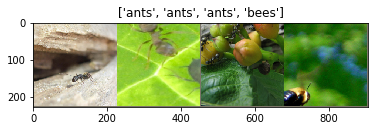

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
%%markdown
## Train model 

## Train model 


Now, let's write a general function to train a model. Here, we will illustrate:
    
    *   Scheduling the lerning rate
    *   Saveing the bast model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            # zero grad parameters gradients
            optimizer.zero_grad()
            
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # Backward + optimizer only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # ddep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

it should take around 15-25 min on CPU. On GPU hrough, it takes less than a minute:

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
val Loss: 0.0025 Acc: 0.0065
Epoch 1/24
----------
val Loss: 0.0088 Acc: 0.0000
Epoch 2/24
----------
val Loss: 0.0051 Acc: 0.0000
Epoch 3/24
----------
val Loss: 0.0083 Acc: 0.0000
Epoch 4/24
----------
val Loss: 0.0102 Acc: 0.0000
Epoch 5/24
----------
val Loss: 0.0048 Acc: 0.0000
Epoch 6/24
----------
val Loss: 0.0035 Acc: 0.0065
Epoch 7/24
----------
val Loss: 0.0013 Acc: 0.0065
Epoch 8/24
----------
val Loss: 0.0040 Acc: 0.0065
Epoch 9/24
----------
val Loss: 0.0017 Acc: 0.0065
Epoch 10/24
----------
val Loss: 0.0041 Acc: 0.0065
Epoch 11/24
----------
val Loss: 0.0014 Acc: 0.0065
Epoch 12/24
----------
val Loss: 0.0019 Acc: 0.0065
Epoch 13/24
----------
val Loss: 0.0016 Acc: 0.0065
Epoch 14/24
----------
val Loss: 0.0043 Acc: 0.0065
Epoch 15/24
----------
val Loss: 0.0004 Acc: 0.0065
Epoch 16/24
----------
val Loss: 0.0029 Acc: 0.0065
Epoch 17/24
----------
val Loss: 0.0003 Acc: 0.0065
Epoch 18/24
----------
val Loss: 0.0017 Acc: 0.0065
Epoch 19/24
----------

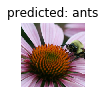

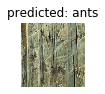

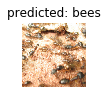

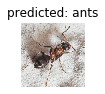

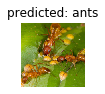

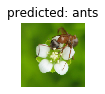

In [0]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Paramters of newly constructed modules have requires_grad=True by default
num_iters = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of finally layer are being optimized as
# opossed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exr_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exr_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
val Loss: 0.0066 Acc: 0.0000
Epoch 1/24
----------
val Loss: 0.0057 Acc: 0.0000
Epoch 2/24
----------
val Loss: 0.0017 Acc: 0.0065
Epoch 3/24
----------
val Loss: 0.0011 Acc: 0.0065
Epoch 4/24
----------
val Loss: 0.0012 Acc: 0.0065
Epoch 5/24
----------
val Loss: 0.0149 Acc: 0.0000
Epoch 6/24
----------
val Loss: 0.0040 Acc: 0.0065
Epoch 7/24
----------
val Loss: 0.0025 Acc: 0.0065
Epoch 8/24
----------
val Loss: 0.0089 Acc: 0.0000
Epoch 9/24
----------
val Loss: 0.0059 Acc: 0.0000
Epoch 10/24
----------
val Loss: 0.0097 Acc: 0.0000
Epoch 11/24
----------
val Loss: 0.0081 Acc: 0.0000
Epoch 12/24
----------
val Loss: 0.0028 Acc: 0.0065
Epoch 13/24
----------
val Loss: 0.0071 Acc: 0.0000
Epoch 14/24
----------
val Loss: 0.0026 Acc: 0.0065
Epoch 15/24
----------
val Loss: 0.0005 Acc: 0.0065
Epoch 16/24
----------
val Loss: 0.0068 Acc: 0.0000
Epoch 17/24
----------
val Loss: 0.0082 Acc: 0.0000
Epoch 18/24
----------
val Loss: 0.0004 Acc: 0.0065
Epoch 19/24
----------

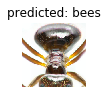

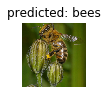

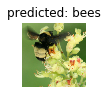

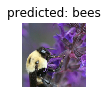

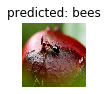

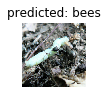

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()